2025-09-26 07:24:16.223806: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-26 07:24:16.224294: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 07:24:16.287271: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-26 07:24:24.220502: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

Loading trained LSTM model …
✓ Model loaded.
Found saved scalers. Loading …
Phase-1 PD subjects: 48
Restriction applied: COMED=0 for all simulated subjects
Running QD and QW Monte-Carlo …


2025-09-26 07:24:26.861181: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


QD MC (COMED=0):   0%|          | 0/200 [00:00<?, ?it/s]

2025-09-26 07:24:27.731544: E tensorflow/core/util/util.cc:131] oneDNN supports DT_BOOL only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


QW MC (COMED=0):   0%|          | 0/200 [00:00<?, ?it/s]

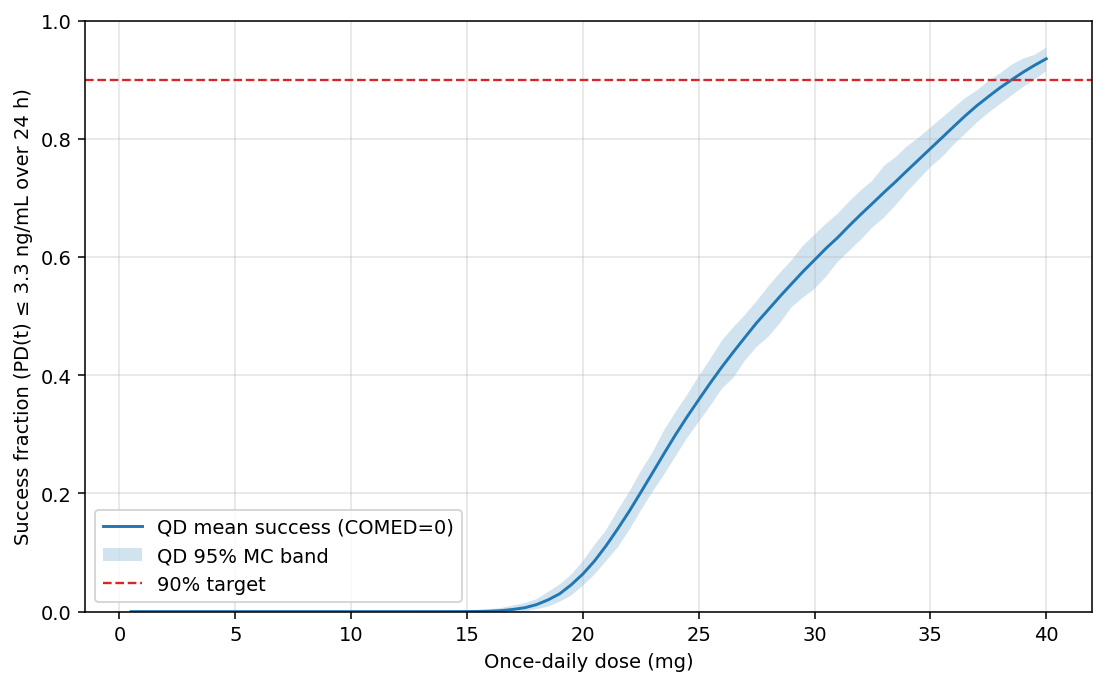

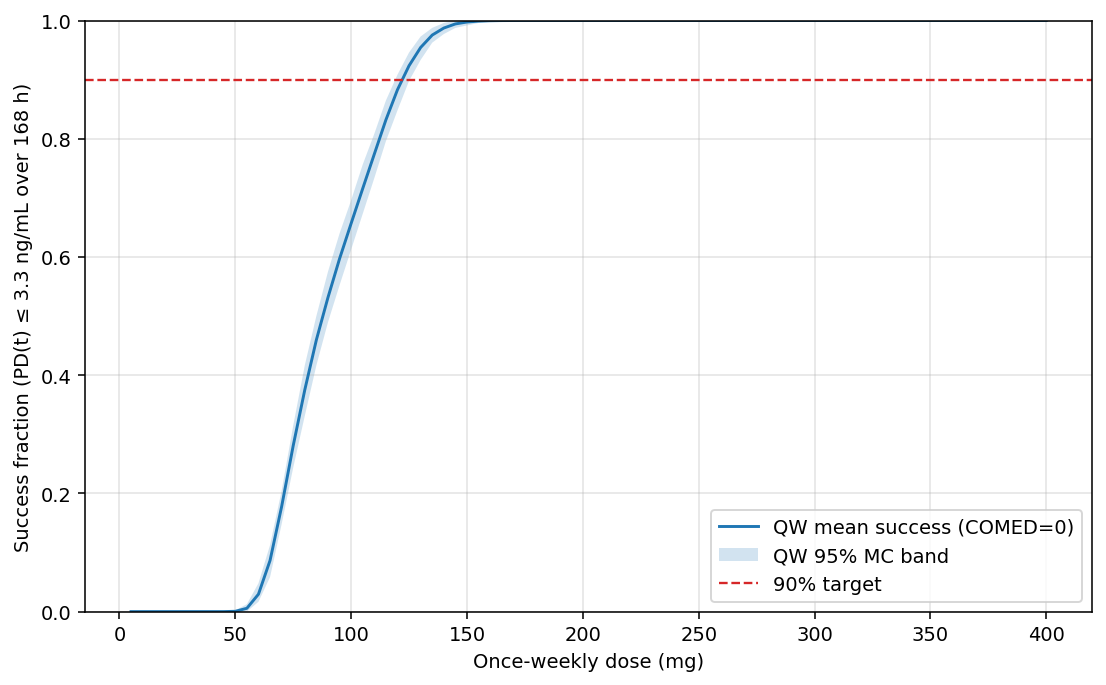


=== No-concomitant medication scenario (COMED=0) ===
QD minimal dose for ≥90% success (MC mean): 38.7 mg  | 95% CI: [38.0, 39.5] mg
QD minimal dose (on mean curve):            39.0 mg
QW minimal dose for ≥90% success (MC mean): 124 mg  | 95% CI: [120.0, 130.0] mg
QW minimal dose (on mean curve):            125 mg

Debug:
  QD grid top = 40.0 mg; QD max success at grid top = 0.935

Saved:
  qd_no_comed_dose_success.png
  qw_no_comed_dose_success.png
  qd_no_comed_dose_success_summary.csv
  qw_no_comed_dose_success_summary.csv


In [1]:
# -*- coding: utf-8 -*-
"""
No-concomitant medication scenario (COMED=0):
Optimal once-daily & once-weekly doses for ≥90% success (PD(t) ≤ 3.3 ng/mL over full interval)
-----------------------------------------------------------------------------------------------
- Loads trained LSTM (no retrain)
- Loads/rebuilds time & PD scalers from Phase-1 data
- Monte Carlo over Phase-1 BW distribution (with resampling); COMED forced to 0
- QD grid auto-extends (0.5 mg steps) until it crosses 90% success
- Outputs dose→success curves + minimal 90% dose (mean & 95% CI) for QD and QW
"""

import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 140

from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.get_logger().setLevel("ERROR")
from tensorflow.keras import models

# ----------------------------- Config -----------------------------
MODEL_PATH        = "lstm_best.h5"   # your trained LSTM model path
STRICT_THRESHOLD  = 3.3              # ng/mL
TAU_QD            = 24.0             # once-daily interval
TAU_QW            = 168.0            # once-weekly interval

# Dose grids
QD_MAX_DOSE       = 40.0             # mg (initial ceiling; grid will auto-extend if needed)
QD_STEP           = 0.5              # mg step
QW_MAX_DOSE       = 400.0            # mg
QW_STEP           = 5.0              # mg step

# Monte Carlo
K_EXPAND          = 10               # ~10× the Phase-1 N
R_MC              = 200              # MC replicates (raise for tighter CIs)
USE_EMPIRICAL_BW  = True             # use Phase-1 BW resampling (recommended here)
BW_JITTER_GCV     = 0.10             # log-normal jitter on BW if using empirical
TIME_SCALER_PATH  = "time_scaler_qd.pkl"
Y_SCALER_PATH     = "y_scaler_pd.pkl"

SEED              = 42
rng = np.random.default_rng(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ----------------------- Utilities: IO for scalers ----------------
def save_scaler(scaler: StandardScaler, path: str):
    import joblib
    joblib.dump(scaler, path)

def load_scaler(path: str) -> StandardScaler:
    import joblib
    return joblib.load(path)

# ------------------------- Robust model load ----------------------
def load_trained_model(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Missing '{path}'. Train your LSTM first (produces an .h5 or SavedModel dir)."
        )
    try:
        # Fix Keras v3 'mse' issue for legacy H5 models
        return models.load_model(
            path,
            custom_objects={"mse": tf.keras.losses.MeanSquaredError()},
            compile=False,
        )
    except TypeError:
        return models.load_model(path, compile=False)

print("Loading trained LSTM model …")
model = load_trained_model(MODEL_PATH)
print("✓ Model loaded.")

# ------------------- Prepare / rebuild scalers --------------------
def load_or_build_scalers():
    have_both = os.path.exists(TIME_SCALER_PATH) and os.path.exists(Y_SCALER_PATH)
    if have_both:
        print("Found saved scalers. Loading …")
        return load_scaler(TIME_SCALER_PATH), load_scaler(Y_SCALER_PATH)

    print("Preparing scalers from Phase-1 data …")
    df = pd.read_csv("EstData.csv")
    for c in ["ID","BW","COMED","DOSE","TIME","DV","EVID","MDV","DVID","AMT"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna(subset=["ID","TIME","EVID","MDV","DVID"])
    df = df[df["TIME"] >= 0].sort_values(["ID","TIME"])

    obs = df[(df["EVID"]==0) & (df["MDV"]==0)]
    pd_df = obs[obs["DVID"]==2].copy()

    def infer_tau(s):
        d = s[s["EVID"]==1]
        if len(d):
            t = np.sort(d["TIME"].dropna().unique())
            return float(np.median(np.diff(t))) if len(t)>=2 else TAU_QD
        return TAU_QD

    def last_window(s, tau, min_points=3, max_expand=8.0):
        if s.empty: return s.iloc[0:0].copy()
        tmax = float(s["TIME"].max()); best, bestn = s.iloc[0:0].copy(), 0; f=1.0
        while f <= max_expand:
            w = s[(s["TIME"]>=tmax - tau*f) & (s["TIME"]<=tmax)]
            if len(w)>bestn: best, bestn = w.copy(), len(w)
            if len(w) >= min_points: return w.sort_values("TIME")
            f *= 1.5
        return best.sort_values("TIME")

    def resample_to_grid(time, value, grid):
        if len(time)==0: return np.full_like(grid, np.nan, float)
        ix = np.argsort(time)
        t, v = np.asarray(time)[ix], np.asarray(value)[ix]
        out = np.interp(grid, t - t.min(), v, left=np.nan, right=np.nan)
        # repair NaNs (forward-fill then linear)
        if np.isnan(out[0]):
            first = np.nanmin(np.where(~np.isnan(out))[0])
            out[:first] = out[first]
        m = np.isnan(out)
        if m.any():
            out[m] = np.interp(np.where(m)[0], np.where(~m)[0], out[~m])
        return out

    # Build 24-point PD sequences to fit scalers
    T = 24
    grid_24h = np.linspace(0, TAU_QD, T)
    y_all, t_all = [], []
    for sid, s in pd_df.groupby("ID"):
        tau = infer_tau(df[df["ID"]==sid])
        w = last_window(s.sort_values("TIME"), tau, 3, 8.0)
        if w.empty: continue
        vg = resample_to_grid(w["TIME"].values.astype(float),
                              w["DV"].values.astype(float), grid_24h)
        y_all.append(vg)
        t_all.append(grid_24h / TAU_QD)

    if not y_all:
        raise RuntimeError("Could not build PD sequences to fit scalers from EstData.csv.")

    y_all = np.asarray(y_all, float)  # (N,24)
    t_all = np.asarray(t_all, float)  # (N,24)

    y_scaler = StandardScaler().fit(y_all.reshape(-1,1))
    time_scaler = StandardScaler().fit(t_all.reshape(-1,1))

    save_scaler(time_scaler, TIME_SCALER_PATH)
    save_scaler(y_scaler, Y_SCALER_PATH)
    print("✓ Scalers fitted & saved.")
    return time_scaler, y_scaler

time_scaler, y_scaler = load_or_build_scalers()

# ---------------------- Phase-1 BW empirical ---------------------
df_phase1 = pd.read_csv("EstData.csv")
for c in ["ID","BW","COMED","DOSE","TIME","DV","EVID","MDV","DVID","AMT"]:
    if c in df_phase1.columns: df_phase1[c] = pd.to_numeric(df_phase1[c], errors="coerce")

obs = df_phase1[(df_phase1["EVID"]==0) & (df_phase1["MDV"]==0)]
N_base = int(obs[obs["DVID"]==2]["ID"].nunique())
if N_base < 1:
    N_base = 48  # fallback

BW_per_id = []
for sid, s in df_phase1.groupby("ID"):
    if s["BW"].notna().any():
        BW_per_id.append(float(s["BW"].dropna().iloc[0]))
BW_per_id = np.array([b for b in BW_per_id if np.isfinite(b) and b>0])
if BW_per_id.size == 0:
    BW_per_id = np.array([70.0])

# ---------------------- Simulators (QD & QW) ---------------------
def make_batch(TAU, Tpoints, BW, COMED, dose_mg, tau_norm):
    """
    Features: [time_norm, dose_mgkg, comed, tau_norm]
    """
    N = len(BW)
    tgrid = np.linspace(0, TAU, Tpoints)
    dose_mgkg = dose_mg / np.clip(BW, 1e-6, None)
    Xb = np.stack([
        (tgrid/TAU) * np.ones((N, Tpoints)),      # time_norm
        np.tile(dose_mgkg[:, None], (1, Tpoints)),# mg/kg
        np.tile(COMED[:, None], (1, Tpoints)),    # 0/1
        np.full((N, Tpoints), tau_norm, float)    # tau_norm
    ], axis=-1).astype(float)
    # scale time channel with training scaler
    Xb[..., 0] = time_scaler.transform(Xb[..., 0].reshape(-1,1)).reshape(N, Tpoints)
    return Xb, tgrid

def predict_qd_pd_ngml(BW, COMED, dose_mg, Tpoints=24):
    Xb, tgrid = make_batch(TAU_QD, Tpoints, BW, COMED, dose_mg, tau_norm=1.0)
    yhat_z = model.predict(Xb, verbose=0).squeeze(-1)                     # (N,Tpoints)
    yhat   = y_scaler.inverse_transform(yhat_z.reshape(-1,1)).reshape(yhat_z.shape)
    return yhat, tgrid

def predict_qw_pd_ngml(BW, COMED, dose_weekly_mg, Tpoints=168):
    Xb, tgrid = make_batch(TAU_QW, Tpoints, BW, COMED, dose_weekly_mg, tau_norm=TAU_QW/TAU_QD)
    yhat_z = model.predict(Xb, verbose=0).squeeze(-1)                     # (N,Tpoints)
    yhat   = y_scaler.inverse_transform(yhat_z.reshape(-1,1)).reshape(yhat_z.shape)
    return yhat, tgrid

# ------------------------- MC helpers -----------------------------
def draw_population_no_comed(n_base: int):
    """
    Draws a synthetic cohort of size ~n_base*K_EXPAND.
    - BW: empirical Phase-1 resampling + 10% log-normal jitter
    - COMED: forced to 0 (restriction)
    """
    idx = rng.integers(0, BW_per_id.size, size=n_base*K_EXPAND)
    BW  = BW_per_id[idx] * np.exp(rng.normal(0.0, BW_JITTER_GCV, size=n_base*K_EXPAND))
    BW  = np.clip(BW, 30.0, 200.0)  # sanity bounds
    COM = np.zeros_like(BW, dtype=int)  # <-- restriction: no concomitant medication
    return BW, COM

def mc_success_curve_qd(dose_grid, N_base, R=R_MC):
    succ_mat = np.zeros((R, len(dose_grid)))
    dose90   = np.full(R, np.nan)
    for r in tqdm(range(R), desc="QD MC (COMED=0)"):
        BW, COM = draw_population_no_comed(N_base)
        s = []
        for d in dose_grid:
            yhat, _ = predict_qd_pd_ngml(BW, COM, d, Tpoints=24)
            ok = (np.nanmax(yhat, axis=1) <= STRICT_THRESHOLD)  # PD ≤ thresh for all 24 h
            s.append(ok.mean())
        s = np.array(s)
        succ_mat[r,:] = s
        i90 = np.where(s >= 0.90)[0]
        if i90.size:
            dose90[r] = float(dose_grid[i90[0]])
    return succ_mat, dose90

def mc_success_curve_qw(dose_grid, N_base, R=R_MC):
    succ_mat = np.zeros((R, len(dose_grid)))
    dose90   = np.full(R, np.nan)
    for r in tqdm(range(R), desc="QW MC (COMED=0)"):
        BW, COM = draw_population_no_comed(N_base)
        s = []
        for d in dose_grid:
            yhat, _ = predict_qw_pd_ngml(BW, COM, d, Tpoints=168)
            ok = (np.nanmax(yhat, axis=1) <= STRICT_THRESHOLD)  # PD ≤ thresh for all 168 h
            s.append(ok.mean())
        s = np.array(s)
        succ_mat[r,:] = s
        i90 = np.where(s >= 0.90)[0]
        if i90.size:
            dose90[r] = float(dose_grid[i90[0]])
    return succ_mat, dose90

def summarize_curve(succ_mat, dose_grid, dose90_samples):
    succ_mean = succ_mat.mean(axis=0)
    succ_lo   = np.percentile(succ_mat, 2.5, axis=0)
    succ_hi   = np.percentile(succ_mat, 97.5, axis=0)
    if np.isfinite(dose90_samples).any():
        d90_mean = float(np.nanmean(dose90_samples))
        d90_ci   = (float(np.nanpercentile(dose90_samples, 2.5)),
                    float(np.nanpercentile(dose90_samples, 97.5)))
    else:
        d90_mean, d90_ci = np.nan, (np.nan, np.nan)
    # minimal dose on the mean curve (grid-aligned)
    idx = np.where(succ_mean >= 0.90)[0]
    d90_mean_curve = float(dose_grid[idx[0]]) if idx.size else np.nan
    return succ_mean, succ_lo, succ_hi, d90_mean, d90_ci, d90_mean_curve

# ----------------- QD auto-extend helper (NEW) --------------------
def run_qd_until_cross(N_base,
                       start=0.5,
                       step=0.5,
                       initial_max=40.0,
                       extend_by=20.0,
                       max_extends=10,
                       hard_cap=240.0):
    """
    Builds the QD dose grid and runs MC, extending the grid until the mean
    success curve crosses 0.90 or we hit 'hard_cap'.
    """
    grid = np.arange(start, initial_max + step, step)
    succ_qd, d90_qd = mc_success_curve_qd(grid, N_base, R=R_MC)
    succ_mean = succ_qd.mean(axis=0)
    if float(np.nanmax(succ_mean)) >= 0.90:
        return grid, succ_qd, d90_qd

    extends = 0
    while extends < max_extends and grid[-1] < hard_cap:
        last = grid[-1]
        new_top = min(last + extend_by, hard_cap)
        grid = np.arange(step, new_top + step, step)
        succ_qd, d90_qd = mc_success_curve_qd(grid, N_base, R=R_MC)
        succ_mean = succ_qd.mean(axis=0)
        if float(np.nanmax(succ_mean)) >= 0.90:
            return grid, succ_qd, d90_qd
        extends += 1

    # Return best effort (may still be < 0.90 if truly unreachable)
    return grid, succ_qd, d90_qd

# -------------------- Build dose grids & run MC -------------------
qd_initial_max = QD_MAX_DOSE  # starting ceiling for QD
qw_grid = np.arange(QW_STEP, QW_MAX_DOSE+QW_STEP, QW_STEP)

print(f"Phase-1 PD subjects: {N_base}")
print("Restriction applied: COMED=0 for all simulated subjects")
print("Running QD and QW Monte-Carlo …")

# --- QD: auto-extend until 90% crossing (NEW) ---
qd_grid, succ_qd, d90_qd = run_qd_until_cross(
    N_base,
    start=QD_STEP,
    step=QD_STEP,
    initial_max=qd_initial_max,
    extend_by=20.0,
    max_extends=10,
    hard_cap=240.0
)

# --- QW: run normally ---
succ_qw, d90_qw = mc_success_curve_qw(qw_grid, N_base, R=R_MC)

qd_mean, qd_lo, qd_hi, qd_d90, qd_d90_ci, qd_d90_curve = summarize_curve(succ_qd, qd_grid, d90_qd)
qw_mean, qw_lo, qw_hi, qw_d90, qw_d90_ci, qw_d90_curve = summarize_curve(succ_qw, qw_grid, d90_qw)

# -------------------------- Plots & CSV ---------------------------
plt.figure(figsize=(8,5))
plt.plot(qd_grid, qd_mean, label="QD mean success (COMED=0)")
plt.fill_between(qd_grid, qd_lo, qd_hi, alpha=0.2, label="QD 95% MC band")
plt.axhline(0.90, color="tab:red", ls="--", lw=1.2, label="90% target")
plt.ylim(0,1); plt.xlabel("Once-daily dose (mg)")
plt.ylabel(f"Success fraction (PD(t) ≤ {STRICT_THRESHOLD} ng/mL over 24 h)")
plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout()
plt.savefig("qd_no_comed_dose_success.png", dpi=180); plt.show()

plt.figure(figsize=(8,5))
plt.plot(qw_grid, qw_mean, label="QW mean success (COMED=0)")
plt.fill_between(qw_grid, qw_lo, qw_hi, alpha=0.2, label="QW 95% MC band")
plt.axhline(0.90, color="tab:red", ls="--", lw=1.2, label="90% target")
plt.ylim(0,1); plt.xlabel("Once-weekly dose (mg)")
plt.ylabel(f"Success fraction (PD(t) ≤ {STRICT_THRESHOLD} ng/mL over 168 h)")
plt.grid(True, alpha=0.35); plt.legend(); plt.tight_layout()
plt.savefig("qw_no_comed_dose_success.png", dpi=180); plt.show()

pd.DataFrame({
    "qd_dose_mg": qd_grid,
    "succ_mean": qd_mean, "succ_lo2p5": qd_lo, "succ_hi97p5": qd_hi
}).to_csv("qd_no_comed_dose_success_summary.csv", index=False)

pd.DataFrame({
    "qw_dose_mg": qw_grid,
    "succ_mean": qw_mean, "succ_lo2p5": qw_lo, "succ_hi97p5": qw_hi
}).to_csv("qw_no_comed_dose_success_summary.csv", index=False)

# --------------------------- Answers ------------------------------
def fmt_ci(ci):
    return f"[{ci[0]:.1f}, {ci[1]:.1f}] mg" if np.isfinite(ci[0]) and np.isfinite(ci[1]) else "N/A"

print("\n=== No-concomitant medication scenario (COMED=0) ===")
print(f"QD minimal dose for ≥90% success (MC mean): {qd_d90:.1f} mg  | 95% CI: {fmt_ci(qd_d90_ci)}")
print(f"QD minimal dose (on mean curve):            {qd_d90_curve:.1f} mg")
print(f"QW minimal dose for ≥90% success (MC mean): {qw_d90:.0f} mg  | 95% CI: {fmt_ci(qw_d90_ci)}")
print(f"QW minimal dose (on mean curve):            {qw_d90_curve:.0f} mg")

print("\nDebug:")
print(f"  QD grid top = {qd_grid[-1]:.1f} mg; QD max success at grid top = {float(qd_mean[-1]):.3f}")

print("\nSaved:")
print("  qd_no_comed_dose_success.png")
print("  qw_no_comed_dose_success.png")
print("  qd_no_comed_dose_success_summary.csv")
print("  qw_no_comed_dose_success_summary.csv")


Saved: dose_target_comparison.csv
    scenario regimen       dose_col                                 path  dose_90pct_mg  dose_75pct_mg  reduction_mg method_90 method_75  grid_min_mg  grid_max_mg  max_success_in_grid
 Baseline QD      QD        dose_mg          mc_dose_success_summary.csv      19.018043      14.270130      4.747914      grid      grid          0.5         40.0              1.00000
No-conmed QD      QD     qd_dose_mg qd_no_comed_dose_success_summary.csv      38.516867      34.101747      4.415120      grid      grid          0.5         40.0              0.93524
 Baseline QW      QW weekly_dose_mg lstm_weekly_dose_success_summary.csv     116.938352     101.312591     15.625761      grid      grid          5.0        400.0              1.00000
No-conmed QW      QW     qw_dose_mg qw_no_comed_dose_success_summary.csv     122.100614     107.938283     14.162332      grid      grid          5.0        400.0              1.00000


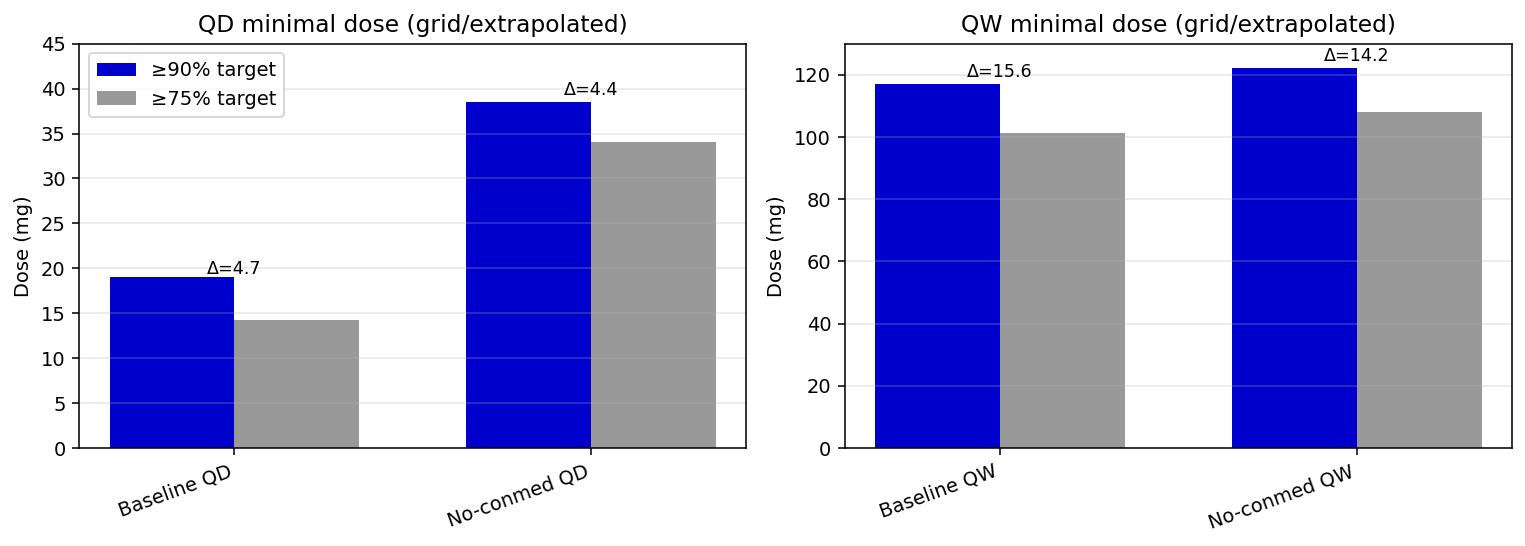

Saved: dose_target_comparison.png

Legend: method_90/method_75 = 'grid' (in-range), 'interp' (in-range interpolation), 'extrap-linear' (beyond grid, linear), 'extrap-logit' (beyond grid, logistic fit). Labels with '*' indicate at least one extrapolated value.


In [6]:
# -*- coding: utf-8 -*-
"""
Compare minimal doses at 90% vs 75% success
-------------------------------------------
Reads dose→success summary CSVs (mean curves) produced by prior MC/LSTM runs and
computes, per scenario:
  - Minimal dose for ≥90% success
  - Minimal dose for ≥75% success
  - Absolute reduction (mg) when going from 90% -> 75%
Works for both QD and QW scenarios.

If the curve does not reach the target within its grid, the script now:
  - Enforces monotonicity (cumulative max over dose)
  - Returns an interpolated dose if the crossing is bracketed
  - Otherwise EXTRAPOLATES beyond the top of the grid using:
      1) linear extrapolation from the last *increasing* segment; or
      2) logistic (logit) least-squares fit as a fallback.
The output adds method tags so you know if a value is extrapolated.

Outputs:
  - dose_target_comparison.csv
  - dose_target_comparison.png
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 140

# ----------------------- Configure your scenarios -----------------------
SCENARIOS = [
    {"name": "Baseline QD",     "path": "mc_dose_success_summary.csv",
     "dose": "dose_mg",         "succ": "succ_mean", "regimen": "QD"},

    {"name": "Baseline QW",     "path": "lstm_weekly_dose_success_summary.csv",
     "dose": "weekly_dose_mg",  "succ": "succ_mean", "regimen": "QW"},

    {"name": "No-conmed QD",    "path": "qd_no_comed_dose_success_summary.csv",
     "dose": "qd_dose_mg",      "succ": "succ_mean", "regimen": "QD"},

    {"name": "No-conmed QW",    "path": "qw_no_comed_dose_success_summary.csv",
     "dose": "qw_dose_mg",      "succ": "succ_mean", "regimen": "QW"},
]

TARGET_STRICT = 0.90
TARGET_LOOSER = 0.75

# --------------------------- Helper functions ---------------------------
def load_curve(path: str, dose_col: str, succ_col: str):
    df = pd.read_csv(path)
    if dose_col not in df.columns or succ_col not in df.columns:
        raise ValueError(f"CSV {path} must contain '{dose_col}' and '{succ_col}'.")
    d = pd.to_numeric(df[dose_col], errors="coerce").to_numpy()
    s = pd.to_numeric(df[succ_col], errors="coerce").to_numpy()
    m = np.isfinite(d) & np.isfinite(s)
    d, s = d[m], s[m]
    order = np.argsort(d)
    d, s = d[order], s[order]
    # enforce non-decreasing success vs dose (theory-consistent)
    s = np.maximum.accumulate(s)
    return d, s

def _interp_between(x0, y0, x1, y1, yt):
    # Linear interpolation to x at y=yt (assumes y1>y0, yt in [y0,y1])
    if y1 == y0:
        return x1  # degenerate; just take the upper x
    return x0 + (yt - y0) * (x1 - x0) / (y1 - y0)

def _linear_extrapolate(d, s, target):
    """
    Use the last *increasing* segment to linearly extrapolate to target.
    Returns (dose, 'extrap-linear') or (np.nan, 'fail') if not possible.
    """
    inc_idx = np.where(np.diff(s) > 1e-9)[0]
    if inc_idx.size == 0:
        return np.nan, "fail"
    i = inc_idx[-1]
    x0, y0, x1, y1 = d[i], s[i], d[i+1], s[i+1]
    if y1 >= target:
        return _interp_between(x0, y0, x1, y1, target), "interp"
    if y1 <= y0 + 1e-9:
        return np.nan, "fail"
    slope = (y1 - y0) / max(1e-12, (x1 - x0))
    x_t = x1 + (target - y1) / max(1e-12, slope)
    return float(x_t), "extrap-linear"

def _logit(x):
    x = np.clip(x, 1e-6, 1-1e-6)
    return np.log(x / (1.0 - x))

def _inv_logit(z):
    return 1.0 / (1.0 + np.exp(-z))

def _logistic_extrapolate(d, s, target):
    """
    Fit logit(s) ~ a + b*d (least squares), solve for dose at target.
    Returns (dose, 'extrap-logit') or (np.nan, 'fail').
    """
    y = np.clip(s, 1e-6, 1-1e-6)
    z = _logit(y)
    X = np.vstack([np.ones_like(d), d]).T
    try:
        beta, *_ = np.linalg.lstsq(X, z, rcond=None)
        a, b = beta
        if abs(b) < 1e-12:
            return np.nan, "fail"
        zt = _logit(target)
        x_t = (zt - a) / b
        return float(x_t), "extrap-logit"
    except Exception:
        return np.nan, "fail"

def dose_at_target(dose: np.ndarray, succ: np.ndarray, target: float):
    """
    Minimal dose to achieve >= target using:
      1) in-range interpolation (preferred)
      2) linear extrapolation off last increasing segment
      3) logistic regression extrapolation
    Returns (dose_value, method_tag).
    """
    s = succ
    d = dose

    idx = np.where(s >= target)[0]
    if idx.size:
        i = idx[0]
        if i == 0:
            return float(d[0]), "grid"
        return float(_interp_between(d[i-1], s[i-1], d[i], s[i], target)), "grid"

    x_lin, tag = _linear_extrapolate(d, s, target)
    if np.isfinite(x_lin):
        return float(x_lin), tag

    x_log, tag = _logistic_extrapolate(d, s, target)
    if np.isfinite(x_log):
        return float(x_log), tag

    return np.nan, "fail"

# ------------------------------ Compute -------------------------------
rows = []
missing = []

for sc in SCENARIOS:
    path = sc["path"]
    if not os.path.exists(path):
        missing.append(sc["name"])
        continue
    try:
        d, s = load_curve(path, sc["dose"], sc["succ"])
        d90, m90 = dose_at_target(d, s, TARGET_STRICT)
        d75, m75 = dose_at_target(d, s, TARGET_LOOSER)

        rows.append({
            "scenario": sc["name"],
            "regimen": sc["regimen"],
            "dose_col": sc["dose"],
            "path": path,
            "dose_90pct_mg": d90,
            "dose_75pct_mg": d75,
            "reduction_mg": (d90 - d75) if np.isfinite(d90) and np.isfinite(d75) else np.nan,
            "method_90": m90,
            "method_75": m75,
            "grid_max_mg": float(d[-1]) if d.size else np.nan,
            "grid_min_mg": float(d[0]) if d.size else np.nan,
            "max_success_in_grid": float(s.max()) if s.size else np.nan
        })
    except Exception as e:
        missing.append(f"{sc['name']} (error: {e})")

res = pd.DataFrame(rows)

# --------------------------- Save & display ----------------------------
if not res.empty:
    cols = ["scenario","regimen","dose_col","path","dose_90pct_mg","dose_75pct_mg","reduction_mg",
            "method_90","method_75","grid_min_mg","grid_max_mg","max_success_in_grid"]
    res_sorted = res[cols].sort_values(["regimen", "scenario"]).reset_index(drop=True)
    res_sorted.to_csv("dose_target_comparison.csv", index=False)
    print("Saved: dose_target_comparison.csv")
    print(res_sorted.to_string(index=False))
else:
    print("No scenarios found. Please check file paths in SCENARIOS and rerun.")

# ------------------------------- Plot ----------------------------------
# Side-by-side bar chart per scenario: dose at 90% vs 75%, colored by target
if not res.empty:
    COLOR_90 = "#0000CD"  # MediumBlue
    COLOR_75 = "#999999"

    fig, axes = plt.subplots(1, 2, figsize=(11, 4), sharey=False)

    # We'll only add a legend on the LEFT subplot (QD)
    legend_added = False

    for ax, reg in zip(axes, ["QD", "QW"]):
        sub = res_sorted[res_sorted["regimen"] == reg]
        if sub.empty:
            ax.set_visible(False)
            continue

        x = np.arange(len(sub))
        w = 0.35

        bars90 = ax.bar(x - w/2, sub["dose_90pct_mg"], width=w, label="≥90% target", color=COLOR_90)
        bars75 = ax.bar(x + w/2, sub["dose_75pct_mg"], width=w, label="≥75% target", color=COLOR_75)

        ax.set_xticks(x)
        labels = []
        for i, lab in enumerate(sub["scenario"]):
            star = "*" if sub["method_90"].iloc[i] != "grid" or sub["method_75"].iloc[i] != "grid" else ""
            labels.append(lab + star)
        ax.set_xticklabels(labels, rotation=20, ha="right")

        ax.set_title(f"{reg} minimal dose (grid/extrapolated)")
        ax.set_ylabel("Dose (mg)")
        ax.grid(True, axis="y", alpha=0.3)

        # Annotate delta
        for i, (d90, d75) in enumerate(zip(sub["dose_90pct_mg"], sub["dose_75pct_mg"])):
            if np.isfinite(d90) and np.isfinite(d75):
                ax.text(i, max(d90, d75) * 1.02, f"Δ={d90-d75:.1f}", ha="center", fontsize=9)

        # Add legend ONLY on the left subplot
        if not legend_added and reg == "QD":
            ax.legend(loc="upper left", frameon=True)
            legend_added = True
        # y-axis limits per panel
        if reg == "QD":
            ax.set_ylim(0, 45)     # left subplot (QD)
            if not legend_added:
                ax.legend(loc="upper left", frameon=True)
                legend_added = True
        else:
            ax.set_ylim(0, 130)    # right subplot (QW)


    # ensure right subplot (QW) has no legend even if Matplotlib tries to be helpful
    leg = axes[1].get_legend()
    if leg is not None:
        leg.remove()

    plt.tight_layout()
    plt.savefig("dose_target_comparison.png", dpi=240)
    plt.show()
    print("Saved: dose_target_comparison.png")

# ------------------------------ Notes ----------------------------------
if missing:
    print("\nSkipped scenarios (missing/invalid files):")
    for m in missing:
        print(" -", m)

print("\nLegend: method_90/method_75 = 'grid' (in-range), 'interp' (in-range interpolation), "
      "'extrap-linear' (beyond grid, linear), 'extrap-logit' (beyond grid, logistic fit). "
      "Labels with '*' indicate at least one extrapolated value.")
